In [11]:
import sys
import numpy as np


import ee

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterio as rio
import geemap


In [2]:
ee.Initialize()

In [13]:
# Load bbox+fire geometries and push to EE as FeatureCollection
bbox_df = gpd.read_file("../data/unburned/bbox.shp")
fireBounds_df = gpd.read_file("../data/burned/fireBounds.shp")
bounds_df = gpd.read_file("../data/bounds/bounds.shp")

bbox_EE = geemap.gdf_to_ee(bbox_df, geodesic=True)
fireBounds_EE = geemap.gdf_to_ee(fireBounds_df, geodesic=True)

D:\Anaconda\envs\proj\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
D:\Anaconda\envs\proj\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [175]:
taskLst = []
imgLst = []

for fireName, preFireDate, postFireDate, geometry in bounds_df[["FIRE_NAME", "pre-date", "post-date", "geometry"]].values[11:]:

    geometry = ee.Geometry.Rectangle(list(geometry.bounds))

    # Get pre-post fire Landsat 8 images
    preFireImage_l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"
                                    ).filterBounds(geometry
                                    ).filterDate(preFireDate,
                                                 ee.Date(preFireDate).advance(1, "day"))

    postFireImage_l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"
                                     ).filterBounds(geometry
                                     ).filterDate(postFireDate,
                                                  ee.Date(postFireDate).advance(1, "day"))

    preFireImage_l8, postFireImage_l8 = ee.Image(preFireImage_l8.first()), ee.Image(postFireImage_l8.first())

    # Calculate NBR, dNBR, and burn severity
    preFireNBR = preFireImage_l8.normalizedDifference(['SR_B5', 'SR_B7'])
    postFireNBR = postFireImage_l8.normalizedDifference(['SR_B5', 'SR_B7'])
    dNBR = (preFireNBR.subtract(postFireNBR)).multiply(1000).rename("dNBR")

    burnSeverity = dNBR.expression(" (b('dNBR') > 425) ? 4 "    # purple: high severity
                                   ":(b('dNBR') > 225) ? 3 "    # orange: moderate severity
                                   ":(b('dNBR') > 100) ? 2 "    # yellow: low severity
                                   ":(b('dNBR') > -60) ? 1 "    # green: unburned/unchanged
                                   ":0"                         # brown: vegetation growth
                      ).rename("burnSeverity")
    
    # Get SRTM elevation, NLCD land cover, NDVI, and GRIDMET weather
    dem = ee.Image("NASA/NASADEM_HGT/001").select("elevation")
    nlcd2016 = ee.ImageCollection('USGS/NLCD_RELEASES/2016_REL'
                ).filter(ee.Filter.eq('system:index', '2016')).first()
    
    ndvi = postFireImage_l8.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    
    gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET"
               ).filterBounds(geometry
               ).filterDate(ee.Date(postFireDate).advance(-3, "day"), postFireDate
               ).mean()

    # Merge all image bands together
    combined = postFireImage_l8.select('SR_B.'          # post-fire L8 bands 1-7
                              ).addBands(burnSeverity   # classified burn severity
                              ).addBands(dNBR           # dNBR
                              ).addBands(ndvi           # post-fire NDVI
                              ).addBands(dem            # SRTM elevation
                              ).addBands(gridmet        # all GRIDMET bands
                              ).addBands(nlcd2016       # all NLCD bands
                              ).set("FIRE_NAME", fireName)
    imgLst.append(combined)
    
#     task = ee.batch.Export.image.toDrive(image=combined.toUint16(), 
#                                      region = geometry,
#                                      description='first_fire_export',
#                                      folder='fire_folder',
#                                      fileNamePrefix=fireName,
#                                      scale=30,
#                                      crs='EPSG:4326')
#     task.start()

#     taskLst.append(task)

    # apply reducer and save results


In [176]:
imgLst

In [59]:
task.start()

In [88]:
task.status()

{'state': 'COMPLETED',
 'description': 'first_fire_export',
 'creation_timestamp_ms': 1643192780531,
 'update_timestamp_ms': 1643193260527,
 'start_timestamp_ms': 1643192843900,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1KykajDopKN2eMH4PpvYK8iweyTEHvXcc',
  'https://drive.google.com/#folders/1KykajDopKN2eMH4PpvYK8iweyTEHvXcc',
  'https://drive.google.com/#folders/1KykajDopKN2eMH4PpvYK8iweyTEHvXcc',
  'https://drive.google.com/#folders/1KykajDopKN2eMH4PpvYK8iweyTEHvXcc'],
 'attempt': 1,
 'id': 'GJR7JVZIZU5BONBDLZNG7Z4Z',
 'name': 'projects/earthengine-legacy/operations/GJR7JVZIZU5BONBDLZNG7Z4Z'}

In [94]:
test_io = rio.open('../data/REDWOOD VALLEY.tif')

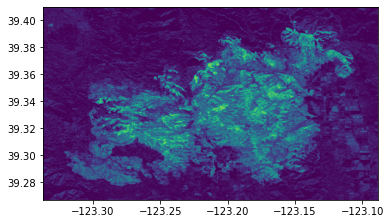

<AxesSubplot:>

In [113]:
from rasterio.plot import show

show((test_io,9))

In [138]:
y_indx = np.arange(test_io.height)
x_indx = np.arange(test_io.width)

index = pd.MultiIndex.from_product([x_indx, y_indx])

In [146]:
test_df = pd.Series(data=band.flatten(),index=index)
test_df

0    0      97
     1      55
     2      30
     3      22
     4      22
            ..
920  526     0
     527    22
     528    36
     529    36
     530    37
Length: 489051, dtype: uint16

In [144]:
test_df.reset_index(drop=True)

,0
0,97
1,55
2,30
3,22
4,22
...,...
489046,0
489047,22
489048,36
489049,36


In [149]:
test_io.descriptions

('SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'burnSeverity',
 'dNBR',
 'NDVI',
 'elevation',
 'pr',
 'rmax',
 'rmin',
 'sph',
 'srad',
 'th',
 'tmmn',
 'tmmx',
 'vs',
 'erc',
 'eto',
 'bi',
 'fm100',
 'fm1000',
 'etr',
 'vpd',
 'landcover',
 'impervious',
 'impervious_descriptor',
 'percent_tree_cover',
 'rangeland_annual_herbaceous',
 'rangeland_bare_ground',
 'rangeland_big_sagebrush',
 'rangeland_herbaceous',
 'rangeland_litter',
 'rangeland_sagebrush',
 'rangeland_sagebrush_height',
 'rangeland_shrub',
 'rangeland_shrub_height')

In [170]:
def get_neighbors(band, coords):
    maxx,maxy = band.shape
    x,y = coords
    n_vals = []
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            neighbor = (x+i, y+j)
            is_bounds = (neighbor[0] >= 0) and (neighbor[0] < maxx) and (neighbor[1] >= 0) and (neighbor[1] < maxy)
            if is_bounds:
                n_vals.append(band[neighbor[0], neighbor[1]])
            else:
                n_vals.append(np.nan)
    return n_vals
    
        
    

In [171]:
get_neighbors(band, (0,0))

[nan, nan, nan, nan, 97, 55, nan, 54, 24]

In [ ]:
'''
TL|TM|TR|
ML|XX|MR|
BL|BM|BR|

TL: top left
TM: top middle
TR: top right
ML: middle left
MR: middle right
BL: bottom left
BM: bottom middle
BR: bottom right


XX: origin point
'''

In [151]:

band[0][0]

97

In [172]:
test_io.read(28)

array([[21, 21, 22, ..., 52, 52, 42],
       [21, 21, 22, ..., 52, 52, 42],
       [71, 71, 71, ..., 52, 42, 42],
       ...,
       [42, 42, 42, ..., 71, 52, 52],
       [42, 42, 42, ..., 71, 71, 71],
       [42, 42, 42, ..., 71, 71, 71]], dtype=uint16)

In [180]:
test_io

<open DatasetReader name='../data/REDWOOD VALLEY.tif' mode='r'>